In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

DATA_PATH = 'data/'

with open(DATA_PATH+'X_test_tokens.txt', 'r') as file: # данные с токенами (до embedding'а)
    X_test = file.read().split('^')[:-1]

with open(DATA_PATH+'y_pred.pkl', 'rb') as file: # предсказания модели на тестовом датасете x_test
    y_pred = pickle.load(file)
    
y_test = np.loadtxt(DATA_PATH+'y_test.txt', dtype=int) # настоящие метки после embedding'а

# # x_test и Y_test нам ни к чему, но можно посмотреть как они выглядят
# with open(DATA_PATH+'Y_test_tokens.txt', 'r') as file:
#     Y_test = file.read().split('^')[:-1]
# x_test = np.loadtxt(DATA_PATH+'x_test.txt', dtype=int)

lens    = np.array([len(X_test[i].split(',')) for i in range(len(X_test))]) # количества токенов
is_shot = np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)             # правильные предсказания модели

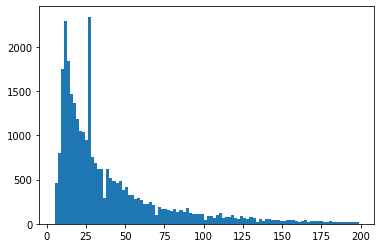

In [3]:
# так выглядит распределение количества токенов на функцию в данном (тестовом) датасете
plt.hist(lens[lens<200], bins = 100);

разобьем всю выборку на три подвыборки примерно одинаковые по длине,\
данные выборки соответствуют меньшему количеству токенов в функции, околомедианному количеству и большему.

In [4]:
# отсечем 'выбросы' 0.97-квантилем
low, mid, high = np.quantile(lens, [0.32,0.65, 0.97])

mask_low = lens<=low
mask_mid = (lens>low) & (lens<=mid)
mask_high = (lens>mid) & (lens<high)
print('размеры подвыборок:',sum(mask_low), sum(mask_mid), sum(mask_high))

размеры подвыборок: 9981 10149 9894


теперь чтобы проверить гипотезы на одинаковость средних accuracy, аггрегируем подвыборки по batch штук и на каждой посчитаем accuracy

In [5]:
def get_accs(mask, batch):
    accs  = [sum(is_shot[mask][i:i+batch])/batch for i in range(0, sum(mask)-batch, batch)]
    resid = sum(mask)%batch
    accs.append(sum(is_shot[mask][-resid:])/resid)
    return accs

batch = 500
low_accs, mid_accs, high_accs = get_accs(mask_low, batch), get_accs(mask_mid, batch), get_accs(mask_high, batch)
print('размеры аггрегированных выборок:',len(low_accs), len(mid_accs), len(high_accs))
print('средние значения:',round(np.mean(low_accs),3), round(np.mean(mid_accs),3), round(np.mean(high_accs),3))

размеры аггрегированных выборок: 20 21 20
средние значения: 0.748 0.846 0.767


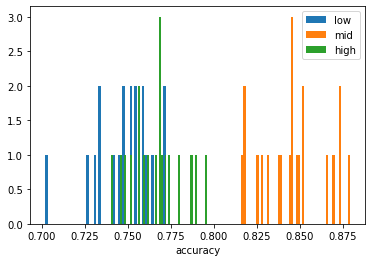

In [6]:
# нарисуем распределения accuracy для наглядности
ax = plt.subplot()
ax.hist(low_accs,  bins = 50, label = 'low')
ax.hist(mid_accs,  bins = 50, label = 'mid')
ax.hist(high_accs, bins = 50, label = 'high')
plt.xlabel('accuracy')
plt.legend()
plt.show()

так как про распределение предсказанных результатов можно сказать очень мало,\
то воспользуемся непараметрическим тестом Mann-Whitney U rank test для гипотезы H0: распределение выборок совпадает\
он часто используется в качестве теста на разницу в матожидании между выюорками.

In [7]:
from scipy.stats import mannwhitneyu
_, p1 = mannwhitneyu(low_accs, mid_accs,  method="asymptotic")
_, p2 = mannwhitneyu(mid_accs, high_accs, method="asymptotic")
_, p3 = mannwhitneyu(low_accs, high_accs, method="asymptotic")
p1, p2, p3 # все p-values < 0.05 => можем отвергнуть H0

(4.576059818966736e-08, 4.5822145927833645e-08, 0.0016088594459584514)

таким образом получили, что для данной модели и для выбранных данных статистически значимым является результат:\
при большем количестве токенов на функцию accuracy выше, но при слишком большом количестве accuracy уменьшается.